- Open the small file and prepare the data for creating shingles
- n-gram = 4

In [169]:
import pandas as pd
import re
import time
import binascii
import numpy as np
import matplotlib.pyplot as plt

In [138]:
small_dataset = 'data/news_articles_small.csv'
df_small_dataset = pd.read_csv(small_dataset)

In [139]:
df_small_dataset.head()

,News_ID,article
0,0,russian foreign minister sergei kozyliev arriv...
1,1,"''''' one one', and , the one theer , it was. ..."
2,2,The threat of an opposition boycott and a smal...
3,3,The Bank of France increased its short-term in...
4,4,british foreign secretary douglas hurd said th...


In [140]:
#Pre-process data
#Convert to lowercase.
df_small_dataset['article'] = df_small_dataset['article'].str.lower()

#Remove punctuation
p = re.compile(r'[^\w\s]+')
df_small_dataset['article'] = [p.sub('', x) for x in df_small_dataset['article'].tolist()]


In [141]:
#Split each document in a list of words
small_dataset_split = []
for idx, row in df_small_dataset.iterrows():
    small_dataset_split.append(row[1].split())

df_small_dataset['splitted'] = small_dataset_split

In [278]:
small_dataset_split[0]

['russian',
 'foreign',
 'minister',
 'sergei',
 'kozyliev',
 'arrived',
 'at',
 'on',
 'of',
 'of',
 'of',
 'of',
 'were',
 'talks',
 'on',
 'the',
 'extension',
 'of',
 'of',
 'nuclear',
 'non',
 'proliferation',
 'treaty',
 'the',
 'united',
 'states',
 'states',
 'forces',
 'opened',
 'a',
 'prison',
 'in',
 'to',
 'to',
 's',
 'and',
 'government',
 'officials',
 'say',
 'to',
 'bring',
 'new',
 'new',
 'back',
 'to',
 'the',
 'world',
 'world',
 'when',
 'the',
 'cubans',
 'were',
 'arrived',
 'people',
 'in',
 'the',
 'city',
 'welcomed',
 'housing',
 'to',
 'the',
 'the',
 'the',
 'jobs',
 'and',
 'boosted',
 'and',
 'the',
 'the',
 'the',
 'worlds',
 's',
 's',
 'dependence',
 'on',
 'education',
 'the',
 'family',
 'of',
 'and',
 'a',
 'one',
 'student',
 'filed',
 'a',
 'a',
 'suit',
 'led',
 'to',
 'a',
 'a',
 'teachers',
 'union',
 'and',
 'and',
 'and',
 'and',
 'pressured',
 'the',
 'students',
 'to',
 'change',
 'the',
 'classroom',
 'space',
 'for',
 'the',
 'to',
 'te

In [ ]:
def random_hash(value, rand_value):
#     return int.from_bytes(hashlib.md5(str(value).encode()).digest(), "big")
    return binascii.crc32(value.to_bytes(32, "little")) & rand_value

In [ ]:
def random_list(n, seed=10):
    random.seed(seed)
    l = []
    for i in range(n):
        r = random.getrandbits(32)
        l.append(r)
    return l

In [144]:
#Add shingles with ngram 4
#Source: https://github.com/chrisjmccormick/MinHash/blob/master/runMinHashExample.py
shingleID = 0

shingledDocs = {}
docIds = []

t0 = time.time()

totalShingles = 0

for idx, row in df_small_dataset.iterrows():
    shingles = set()
    for i in range(0, len(row[2]) - 3):
        shingle = row[2][i]+ " " + row[2][i + 1] + " " + row[2][i + 2] + " " + row[2][i + 3]
        crc =  binascii.crc32(bytes(shingle, 'utf-8')) & 0xffffffff
            # may be replaces by a fingerprint function 
        shingles.add(crc)
        
    shingledDocs[row[0]]= shingles
    docIds.append(row[0])
    totalShingles = totalShingles + (len(row[2]) - 3)

t1 = time.time()
print('Time spent: ', t1-t0)

Time spent:  23.920265197753906


In [172]:
print("Generating random hash functions...")
# Number of hash functions
M = 200
random_values = random_list(M)

signatures = []

Generating random hash functions...
[2454155475, 139951793, 1842064464, 2072586604, 2482883256, 63704871, 885185152, 1986768135, 3493188185, 2110102074, 3537287287, 1191942149, 2806643141, 3481581187, 688180719, 147762233, 2236257879, 2104901561, 1407773507, 326801271, 1073727536, 4090523526, 4092317458, 3202098662, 4280179695, 1551164510, 191368220, 1805587908, 3694363523, 595665893, 2590683945, 1525064232, 1638985225, 1809315075, 1218130959, 3551286111, 2898951949, 1126660590, 1962074861, 750204460, 2945752670, 1301826559, 2842608307, 1557301086, 571136778, 1962492619, 3297838288, 3693882924, 4219432797, 1028130498, 4163490463, 1888272822, 2634218640, 1611656385, 190097954, 2503671984, 17416711, 1012125923, 575407617, 837318074, 4041573968, 3906651747, 1300776207, 2303584948, 1572583374, 3315953022, 3857723518, 1031575033, 1350182240, 2863411522, 2357860530, 1935411051, 1872738711, 2018522846, 279147864, 2804517990, 2510606935, 1394525548, 3625244021, 2155717189, 671814141, 361711457

In [173]:
t0 = time.time()

for doc in docIds:
    signature = []
#     print(shingledDocs[doc])
    for hash_fun in range(M):
        min_value = 1e11
        random_value = random_values[hash_fun]
#         print("random_value ", random_value)
        for shingle in shingledDocs[doc]:
            hash_value = random_hash(shingle, random_value)
#             print("shingle", shingle)
#             print("h_value ", hash_value)
            if hash_value < min_value:
                min_value = hash_value
        signature.append(min_value)
#         print(min_value, " hash number: ", hash_fun, " sign", signature)
    signatures.append(signature)
#     print(signatures)
    
t1 = time.time()
print('Time spent: ', t1-t0)

Time spent:  47.81720471382141


In [252]:
len(signatures[0])

200

In [7]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [175]:
#Calculate Jaccard similarities
t0 = time.time()

JSim_list = []

for i in range(0, len(signatures)):
# Print progress every 100 documents.
    if (i % 100) == 0:
        print(str(i) + " / " + str(len(signatures)))

    docId1 = i
    s1 = signatures[i]

    for j in range(i + 1, len(signatures)):
        # Retrieve the set of shingles for document j.
        docId2 = j
        s2 = signatures[j]

        # Calculate and store the actual Jaccard similarity.
        similarity = jaccard(s1, s2)
        JSim_list.append([docId1, docId2, similarity])

t1= time.time()
print('Time: ', t1-t0)

0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Time:  11.280529737472534


In [253]:
JSim_list[0]

[0, 1, 0.015228426395939087]

In [260]:
sim = pd.DataFrame(JSim_list, columns=["doc1", "doc2", "sim"])
sim['label'] = np.where(sim['sim'] >= 0.5, 1, 0)

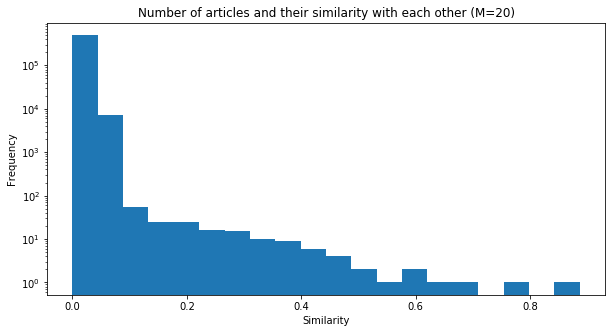

In [171]:
plt.figure(figsize=(10,5))
plt.hist(df.sim, log=True, bins=20)
plt.title("Number of articles and their similarity with each other (M=20)")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

plt.show()

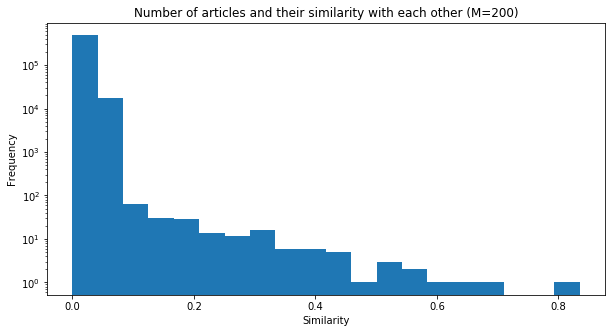

In [267]:
plt.figure(figsize=(10,5))
plt.hist(df.sim, log=True, bins=20)
plt.title("Number of articles and their similarity with each other (M=200)")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

plt.show()

In [182]:
pts

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [184]:
yval

<function __main__.<lambda>(p, r, b)>

In [186]:
def prob_fun(r,b,p):
    return 1-(1-p**r)**b

In [188]:
for op in ops:
    print(prob_fun(op[0], op[1], pts ))

[0.         0.01015168 0.03999856 0.08777586 0.15073333 0.22539487
 0.30787292 0.3941985  0.48062854 0.56389851 0.64139896 0.71126674
 0.77239373 0.82436605 0.86735283 0.90196643 0.929115   0.94986451
 0.96532239 0.97654905 0.98449876 0.98998742 0.99368213 0.99610683
 0.99765794 0.998625   0.9992125  0.99956019 0.99976058 0.99987301
 0.99993441 0.99996702 0.99998387 0.99999233 0.99999646 0.99999841
 0.99999931 0.99999971 0.99999988 0.99999995 0.99999998 0.99999999
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.


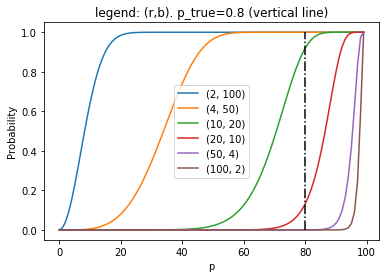

In [191]:
import matplotlib.pyplot as plt
n = 200
ops = [(2,100),(4,50),(10,20),(20,10),(50,4),(100,2)]
pts = np.linspace(0,1,100)

for op in ops:
    plt.plot(prob_fun(op[0], op[1], pts ), label=op)    

# plt.plot(pts,0*pts+0.5,'k--', label="P=1/2")
plt.plot([80,80],[0,1], 'k-.')
plt.legend()
plt.xlabel('p')
plt.ylabel('Probability')
plt.title("legend: (r,b). p_true=0.8 (vertical line)")
plt.show()

In [226]:
M = 100
bs = np.linspace(1,40,10)
rs = M / bs

ops = zip(rs, bs)
len(bs)

10

In [227]:
bs

array([ 1.        ,  5.33333333,  9.66666667, 14.        , 18.33333333,
       22.66666667, 27.        , 31.33333333, 35.66666667, 40.        ])

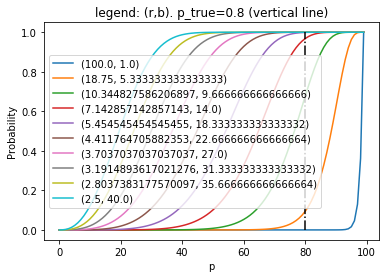

In [228]:

for op in ops:
#     plt.subfigure(subfigsize=(10,5))
    plt.plot(prob_fun(op[0], op[1], pts ), label=op)    

# plt.plot(pts,0*pts+0.5,'k--', label="P=1/2")
plt.plot([80,80],[0,1], 'k-.')
plt.legend()
plt.xlabel('p')
plt.ylabel('Probability')
plt.title("legend: (r,b). p_true=0.8 (vertical line)")
plt.show()

In [48]:
#Calculate Jaccard similarities
t0 = time.time()

JSim = {}
JSim_list = []

for i in range(0, len(docIds)):
# Print progress every 100 documents.
    if (i % 100) == 0:
        print(str(i) + " / " + str(len(docIds)))

    s1 = shingledDocs[docIds[i]]
    JSim[docIds[i]]= {}
    JSim[docIds[i]]['Doc 2']  = []
    JSim[docIds[i]]['JSim'] = []
    for j in range(i + 1, len(docIds)):
        # Retrieve the set of shingles for document j.
        s2 = shingledDocs[docIds[j]]
        JSim[docIds[i]]['Doc 2'] = docIds[i]
        # Calculate and store the actual Jaccard similarity.
        # similarity = len(s1.intersection(s2)) / len(s1.union(s2))
        similarity = jaccard(s1, s2)
        JSim_list.append(similarity)
        JSim[docIds[i]]['JSim'].append(similarity)

t1= time.time()
print('Time: ', t1-t0)

0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
Time:  7.503566741943359


## Compare with real similarity (based on min hash only)

In [268]:
real_sim = pd.read_csv("real_sim.csv")

In [269]:
real_sim.head()

,Unnamed: 0,doc1,doc2,sim
0,0,0,1,0.058333
1,1,0,2,0.058333
2,2,0,3,0.067669
3,3,0,4,0.054852
4,4,0,5,0.072650


In [270]:
real_sim['label'] = np.where(real_sim['sim'] >= 0.8, 1, 0)
print(real_sim['label'].mean()*100)

0.005005005005005005


In [271]:
merged = real_sim.merge(sim, left_on=['doc1','doc2'], right_on=['doc1','doc2'], suffixes=['_real', '_calc'])

In [272]:
merged.head()

,Unnamed: 0,doc1,doc2,sim_real,label_real,sim_calc,label_calc
0,0,0,1,0.058333,0,0.015228,0
1,1,0,2,0.058333,0,0.033592,0
2,2,0,3,0.067669,0,0.030928,0
3,3,0,4,0.054852,0,0.025641,0
4,4,0,5,0.072650,0,0.020408,0


In [273]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(merged[['label_real']],merged[['label_calc']])
print('Confusion Matrix : \n', cm)

total=sum(sum(cm))
#####from confusion matrix calculate accuracy
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity)

Confusion Matrix : 
 [[499474      1]
 [    17      8]]
Accuracy :  0.9999639639639639
Sensitivity :  0.9999979978977926
Specificity :  0.32


In [275]:
merged[['label_real']].count()
merged[['label_real']].sum()

label_real    25
dtype: int64

In [277]:
merged[merged['label_real'] == 1]

,Unnamed: 0,doc1,doc2,sim_real,label_real,sim_calc,label_calc
4955,4955,4,970,0.801105,1,0.342282,0
22678,22678,22,954,0.843023,1,0.307190,0
27491,27491,27,897,1.000000,1,0.834862,1
32901,32901,33,496,0.834356,1,0.515152,1
45495,45495,46,623,0.864000,1,0.351351,0
77554,77554,80,875,0.806667,1,0.111111,0
80803,80803,84,458,0.934211,1,0.606426,1
157215,157215,172,266,0.817143,1,0.459854,0
163368,163368,179,658,0.875706,1,0.544402,1
179033,179033,198,933,0.903846,1,0.544402,1
